#TUIA - Aprendizaje Automático 1

##Trabajo práctico N°1: Regresión lineal

**CORRECCIONES**

- visual
- nulos latitud y longitud con knn (listo)
- categorizar fechas y cant de pasajeros(listo)
- outlaiers de distancia (listo)
- matriz numerica (ver que columanas poneR)
- imprimir coeficientes
- ampliar parametros de optimizacion
- optimizacion de hiperparametros con cross- validation : lasso, ridge, elasticnet, gradiente (ver pq da raro)


Integrantes:
- Moresco, Brisa
- Brizuela Cipolletti, Sofía

### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

# Librerias

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from geopy.distance import geodesic

In [2]:
# https://drive.google.com/file/d/1CQqGndC0Z4G9QNsNbzON2zYT8P9War_U/view?usp=drive_link
!gdown 1CQqGndC0Z4G9QNsNbzON2zYT8P9War_U

Downloading...
From: https://drive.google.com/uc?id=1CQqGndC0Z4G9QNsNbzON2zYT8P9War_U
To: /content/uber_fares.csv
100% 23.5M/23.5M [00:00<00:00, 65.7MB/s]


# Informacion del dataset

In [25]:
# Carga del dataset
df = pd.read_csv("/content/uber_fares.csv")

In [26]:
# Visualización del dataset
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [27]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [29]:
# Cuento los valores faltantes en cada columna.
missing_values = df.isnull().sum()
print("Valores faltantes por columna:\n", missing_values)

Valores faltantes por columna:
 key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [30]:
from sklearn.impute import KNNImputer

# Seleccionamos columnas relevantes para la imputación
columns_for_imputation = [

    'dropoff_longitude', 'dropoff_latitude',

]

# Creamos el imputador con k=5 vecinos (puedes ajustar)
imputer = KNNImputer(n_neighbors=5)

# Aplicamos el imputador
df[columns_for_imputation] = imputer.fit_transform(df[columns_for_imputation])

# Verificamos si aún quedan nulos
print("Valores faltantes después de KNNImputer:\n", df.isnull().sum())


Valores faltantes después de KNNImputer:
 key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [31]:
df.describe()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117375,6.794812,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [32]:
# Eliminamos las variables 'key' y 'date' ya que son columnas que no aportan información relevante para la predicción
df = df.drop(columns=['key', 'date'])

### Variable target 'fare_amount'

In [33]:
# Eliminamos las filas que tengan un valor negativo en la variable target (fare_amount)
df = df[df['fare_amount'] > 0]

In [34]:
df.fare_amount.describe()

,fare_amount
count,199978.000000
mean,11.362649
std,9.897079
min,0.010000
25%,6.000000
50%,8.500000
75%,12.500000
max,499.000000


# Graficos

- A continuacion se visualizan distribuciones de tarifas, días de la semana, horas, y se analiza la cantidad de viajes por hora y día a través de gráficos como boxplots, histogramas y heatmaps. Ademas,  Se clasifican las franjas horarias del día, se limpian valores atípicos en la cantidad de pasajeros, y se agrupan los tipos de viaje (Uber, UberEats, UberXL).

- Luego, se calcula la distancia entre el origen y el destino de los viajes utilizando coordenadas geográficas.
Por ultimo, visualizamos las coordenadas de origen y destino en mapas de calor para identificar áreas de alta densidad de viajes.

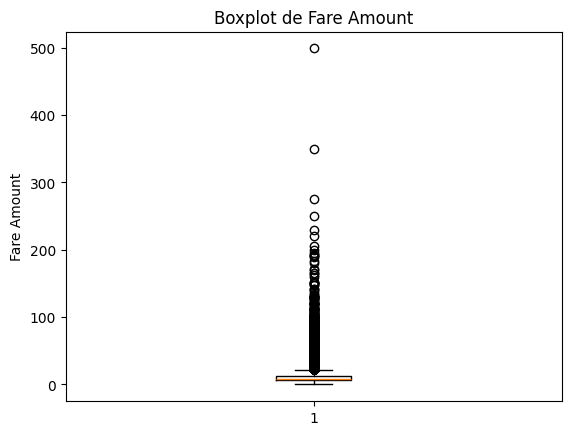

In [35]:
# Boxplot de la variable target
plt.boxplot(df['fare_amount'])
plt.title('Boxplot de Fare Amount')
plt.ylabel('Fare Amount')
plt.show()

### Análisis temporal

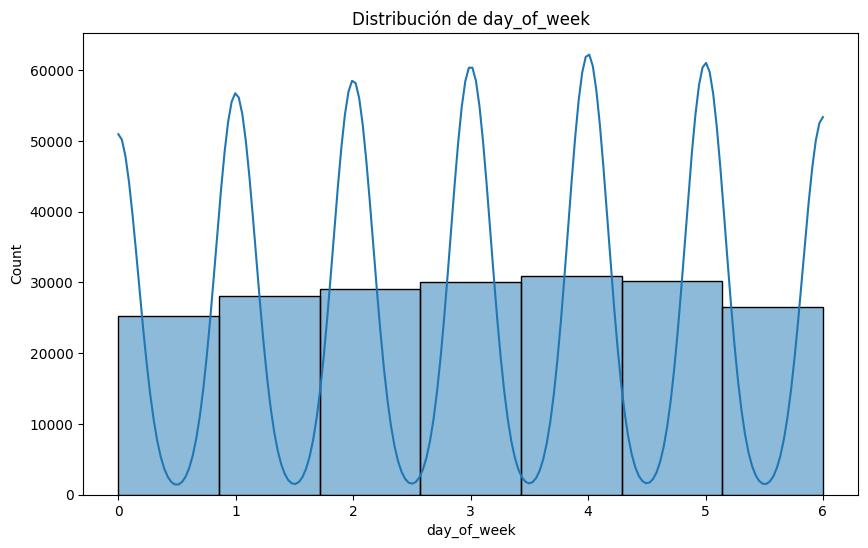

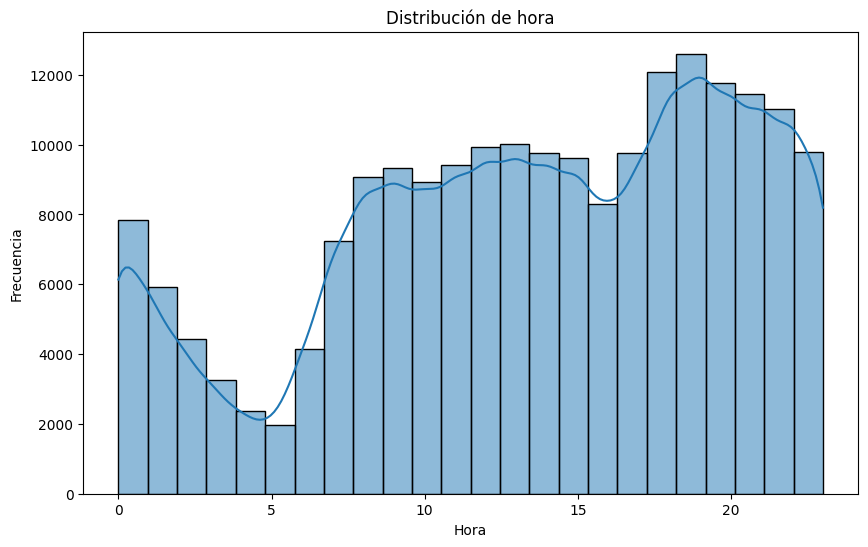

In [36]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour

# Histograma del día de la semana
plt.figure(figsize=(10, 6))
sns.histplot(df['day_of_week'], bins=7, kde=True)
plt.title('Distribución de day_of_week')
plt.show()

# Histograma de la hora
plt.figure(figsize=(10, 6))
sns.histplot(df['hour'], bins=24, kde=True)
plt.title('Distribución de hora')
plt.xlabel('Hora')
plt.ylabel('Frecuencia')
plt.show()


### Heatmap de hora y día de la semana para visualizar a qué hora del día se realizan una mayor cantidad de viajes


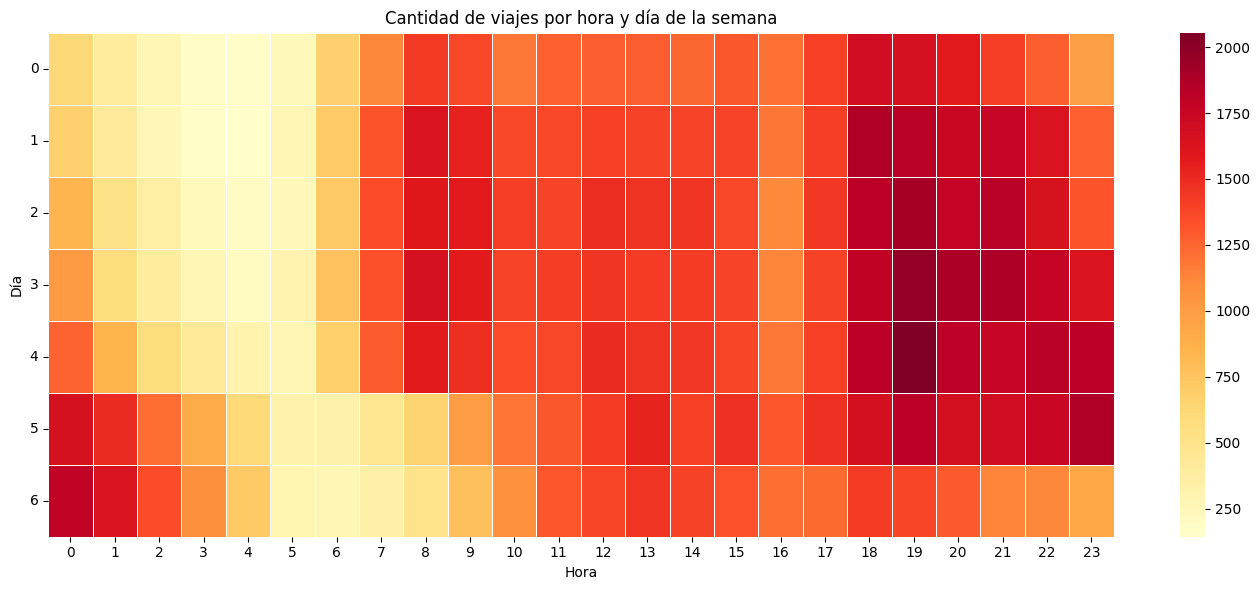

In [37]:
viajes_hora_dia = df.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(viajes_hora_dia, cmap='YlOrRd', linewidths=.5)
plt.title('Cantidad de viajes por hora y día de la semana')
plt.xlabel('Hora')
plt.ylabel('Día')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Promedio de tarifas por día y hora

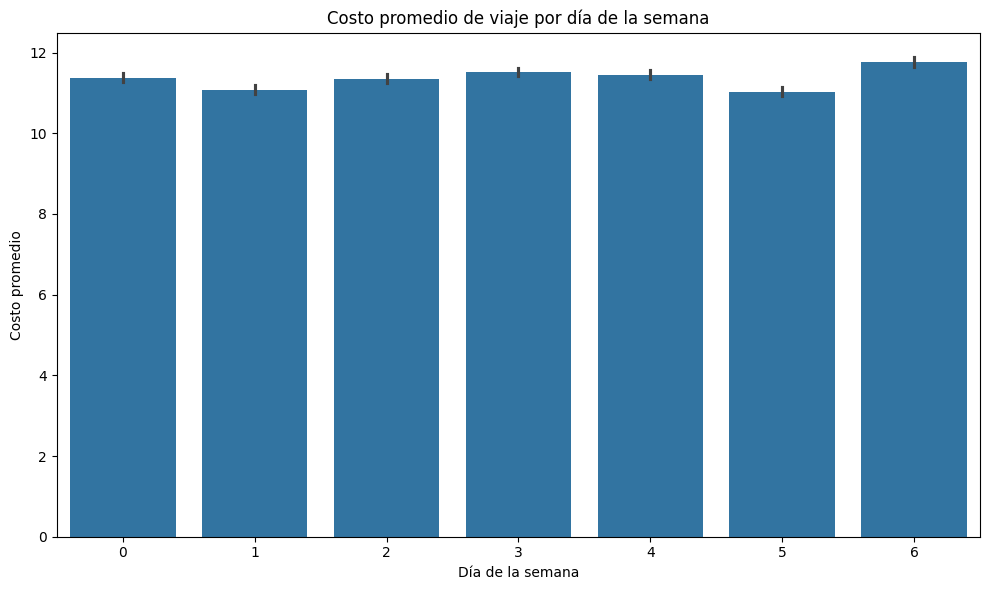

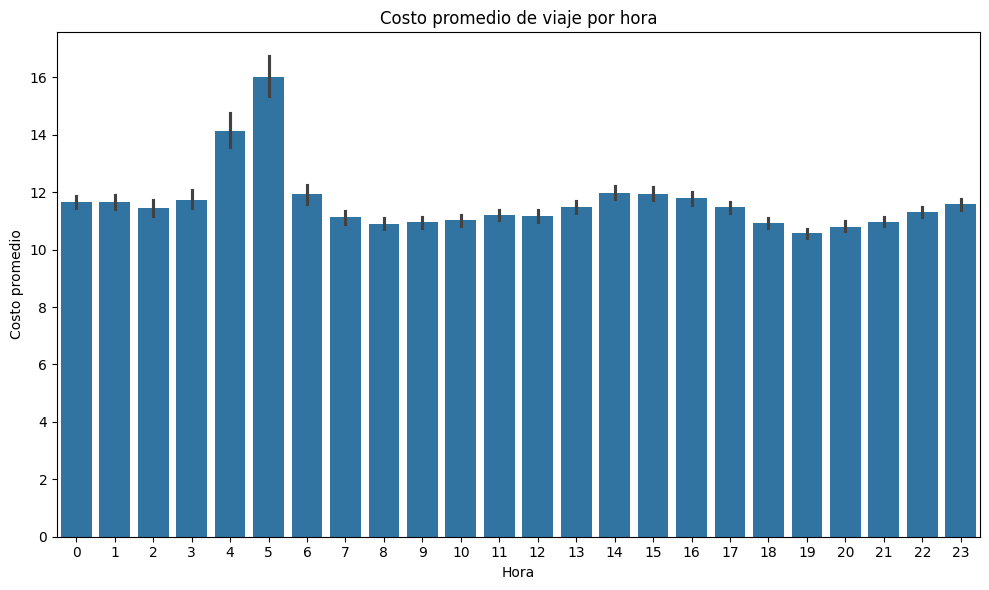

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='fare_amount', data=df)
plt.title('Costo promedio de viaje por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Costo promedio')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='hour', y='fare_amount', data=df)
plt.title('Costo promedio de viaje por hora')
plt.xlabel('Hora')
plt.ylabel('Costo promedio')
plt.tight_layout()
plt.show()


### Cantidad de pasajeros

count    199978.000000
mean          1.684480
std           1.385974
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64


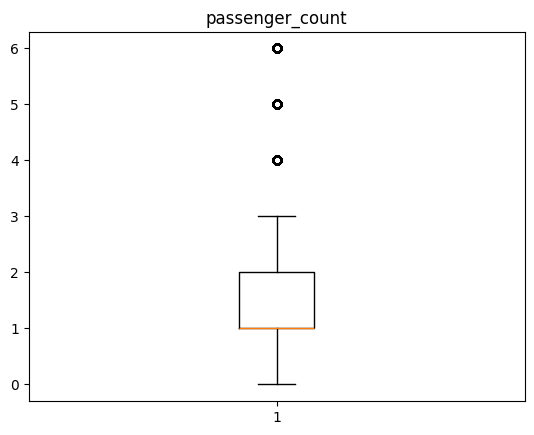

In [39]:
print(df.passenger_count.describe())  # Observación de outliers

# Reemplazo de valores outliers
df.loc[df['passenger_count'] > 6, 'passenger_count'] = df['passenger_count'].median()

# Boxplot
plt.boxplot(df['passenger_count'])
plt.title('passenger_count')
plt.show()


Se observa que hay un valor de 208 como máximo, lo cual es un outlier y debería ser reemplazado por la media, mediana

### Clasificación del tipo de viaje (uber_type)

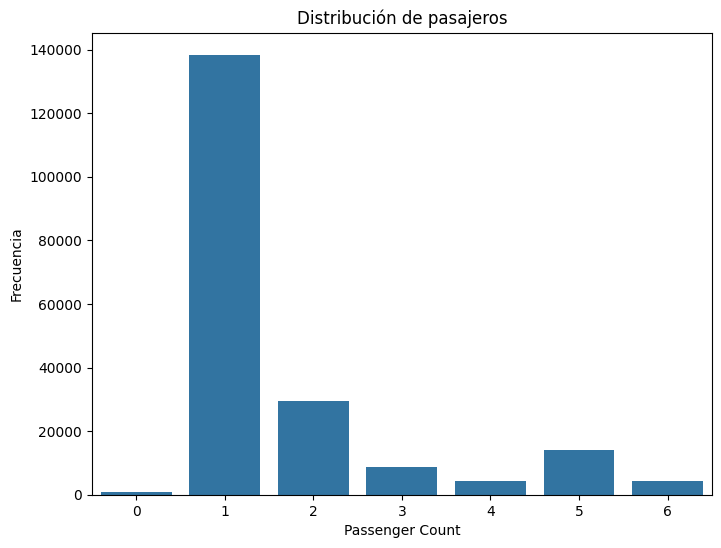

In [40]:
df['uber_type'] = df['passenger_count'].apply(lambda x: 'UberEats' if x == 0 else ('Uber' if x <= 4 else 'UberXL'))
df = pd.get_dummies(df, columns=['uber_type'])

# Conteo por número de pasajeros
plt.figure(figsize=(8, 6))
sns.countplot(x='passenger_count', data=df)
plt.title('Distribución de pasajeros')
plt.xlabel('Passenger Count')
plt.ylabel('Frecuencia')
plt.show()


## Coordenadas y distancia del viaje

Función para calcular la distancia a partir de las latitudes y longitudes del origen y del destino

In [41]:
def calcular_distancia(row):
    return geodesic((row['pickup_latitude'], row['pickup_longitude']),
                    (row['dropoff_latitude'], row['dropoff_longitude'])).km


####  Limpieza de coordenadas

In [42]:
# Limpieza de coordenadas nulas y recorte por límites válidos de NYC
df['dropoff_longitude'].fillna(df['dropoff_longitude'].median(), inplace=True)
df['dropoff_latitude'].fillna(df['dropoff_latitude'].median(), inplace=True)

# Límites razonables para coordenadas en NYC
lon_min, lon_max = -74.3, -73.6
lat_min, lat_max = 40.5, 41.0

# Recorte de coordenadas a los límites válidos
df['pickup_longitude'] = np.clip(df['pickup_longitude'], lon_min, lon_max)
df['pickup_latitude'] = np.clip(df['pickup_latitude'], lat_min, lat_max)
df['dropoff_longitude'] = np.clip(df['dropoff_longitude'], lon_min, lon_max)
df['dropoff_latitude'] = np.clip(df['dropoff_latitude'], lat_min, lat_max)


<ipython-input-42-f96c66ae5e2a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['dropoff_longitude'].fillna(df['dropoff_longitude'].median(), inplace=True)
<ipython-input-42-f96c66ae5e2a>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

In [43]:
df['trip_distance_km'] = df.apply(calcular_distancia, axis=1)


In [44]:
# Eliminación de outliers de distancia
# eliminar viajes demasiado largos (>30 km) o nulos (<0.1 km)
df = df[(df['trip_distance_km'] >= 0.1) & (df['trip_distance_km'] <= 30)]


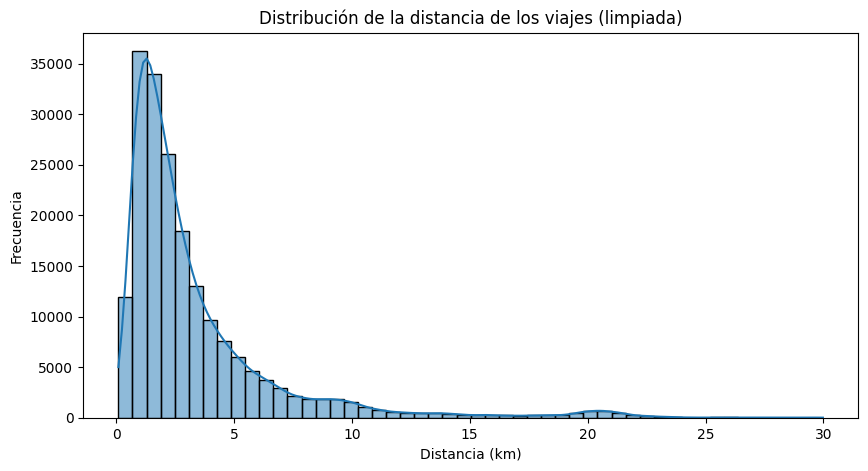

In [45]:
# Visualización de distribución final
plt.figure(figsize=(10, 5))
sns.histplot(df['trip_distance_km'], bins=50, kde=True)
plt.title("Distribución de la distancia de los viajes (limpiada)")
plt.xlabel("Distancia (km)")
plt.ylabel("Frecuencia")
plt.show()

Se eliminaron viajes cuya distancia era menor a 100 metros (posibles errores o viajes cancelados) y mayores a 30 km, ya que representan casos atípicos poco frecuentes en el contexto urbano de NYC. Esto ayuda a reducir el sesgo en el modelo y mejora la calidad del análisis.

### Histogramas de coordenadas

 - Se visualizan las coordenadas de origen y destino en mapas de calor para identificar áreas de alta densidad de viajes.



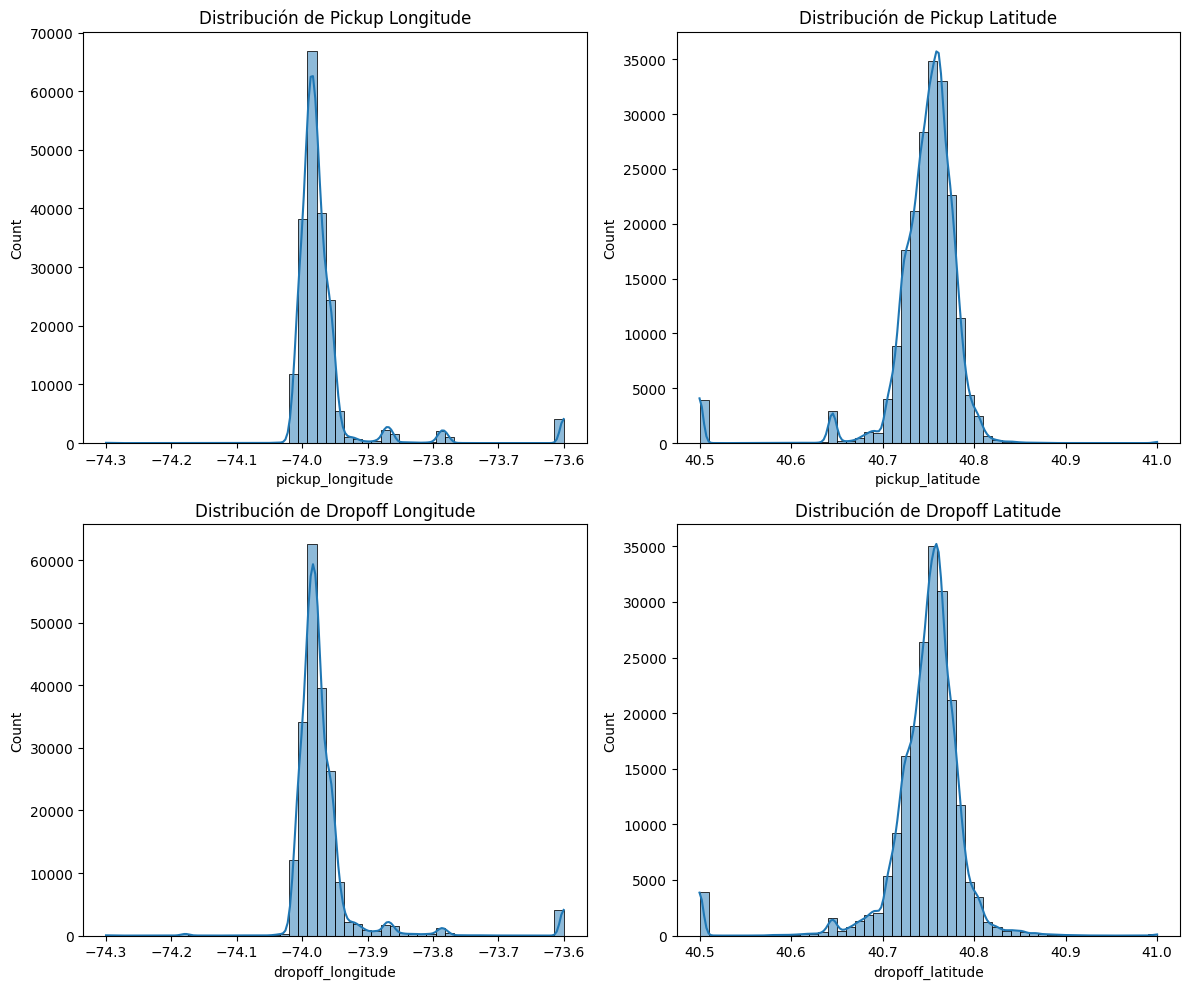

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(df['pickup_longitude'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Pickup Longitude')
sns.histplot(df['pickup_latitude'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribución de Pickup Latitude')
sns.histplot(df['dropoff_longitude'], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Dropoff Longitude')
sns.histplot(df['dropoff_latitude'], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribución de Dropoff Latitude')
plt.tight_layout()
plt.show()


Se puede ver que en la latitud y longitud de origen y destino hay rangos donde se aglomeran los datos, esto nos hace suponer que hay sectores de NY donde se aglomeran los viajes.
Usamos mapas de calor para validar este supuesto.

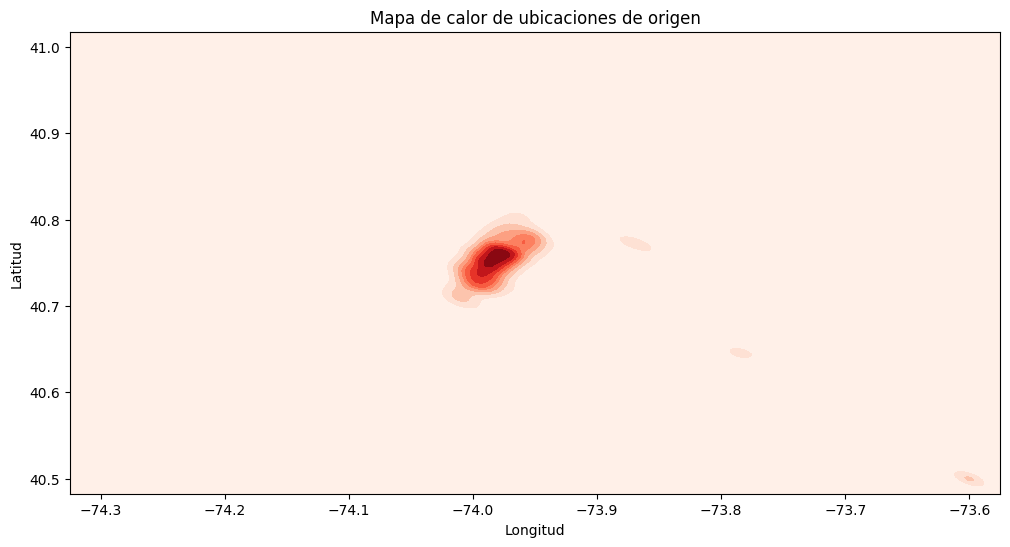

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(x=df['pickup_longitude'], y=df['pickup_latitude'], cmap='Reds', fill=True, thresh=0)
plt.title('Mapa de calor de ubicaciones de origen')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(x=df['dropoff_longitude'], y=df['dropoff_latitude'], cmap='Blues', fill=True, thresh=0)
plt.title('Mapa de calor de ubicaciones de destino')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()


# Dummis


### Clasificación por franja horaria (day_time)

In [59]:
import pandas as pd

def preparar_datos_uber(df):
    # 1. Convertir pickup_datetime a datetime
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

    # 2. Extraer características de la fecha
    df['hour'] = df['pickup_datetime'].dt.hour
    df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
    df['month'] = df['pickup_datetime'].dt.month

    # 3. Categorizar la cantidad de pasajeros
    df['passenger_cat'] = df['passenger_count'].apply(
        lambda x: str(x) if x in [1, 2, 3, 4, 5, 6] else 'other'
    )

    # 4. Categorizar la franja horaria
    def franja_horaria(hour):
        if 0 <= hour < 6:
            return 'madrugada'
        elif 6 <= hour < 12:
            return 'mañana'
        elif 12 <= hour < 18:
            return 'tarde'
        else:
            return 'noche'

    df['franja_horaria'] = df['hour'].apply(franja_horaria)

    # 5. Crear variables dummies (sin la primera categoría para evitar multicolinealidad)
    df = pd.get_dummies(df, columns=['franja_horaria', 'day_of_week', 'month', 'passenger_cat'], drop_first=True)

    return df

# Llamada a la función con tu dataframe
df = preparar_datos_uber(df)

# Verifica las columnas dummies creadas
dummies_cols = [col for col in df.columns if 'franja_horaria_' in col or 'day_of_week_' in col or 'month_' in col or 'passenger_cat_' in col]

# Eliminar duplicados de la lista de columnas dummies
dummies_cols = list(pd.unique(dummies_cols))

# Verifica las columnas seleccionadas para conversión
print("Columnas seleccionadas para conversión:", dummies_cols)

# Convertir las columnas dummies de True/False a 0/1
df[dummies_cols] = df[dummies_cols].astype(int)

# Verifica el resultado
df.head()


<ipython-input-59-17de7de3cbda>:42: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  dummies_cols = list(pd.unique(dummies_cols))


Columnas seleccionadas para conversión: ['franja_horaria_mañana', 'franja_horaria_noche', 'franja_horaria_tarde', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'passenger_cat_2', 'passenger_cat_3', 'passenger_cat_4', 'passenger_cat_5', 'passenger_cat_6', 'passenger_cat_other']


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,hour,uber_type_Uber,...,month_9,month_10,month_11,month_12,passenger_cat_2,passenger_cat_3,passenger_cat_4,passenger_cat_5,passenger_cat_6,passenger_cat_other
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,19,True,...,0,0,0,0,1,1,1,1,0,0
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,20,True,...,0,0,0,0,0,0,0,0,1,1
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,21,True,...,0,0,0,0,0,0,0,0,0,0
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,8,True,...,0,0,0,0,0,0,0,0,1,1
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,17,False,...,0,0,0,0,1,1,1,1,0,0


# Matriz de correlación Numerica

In [69]:
# Calcular la matriz de correlación completa
correlation_matrix = df.corr()

# Eliminar las columnas con correlación menor a un umbral
threshold = 0.8  # Puedes ajustar este valor según lo necesites
columns_to_keep = correlation_matrix.columns[correlation_matrix.abs().max() > threshold]
df_reducido = df[columns_to_keep]

# Calcular la matriz de correlación reducida
correlation_matrix_reducida = df_reducido.corr()

# Mostrar la matriz de correlación reducida
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_reducida, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Reducida')
plt.show()


KeyboardInterrupt: 

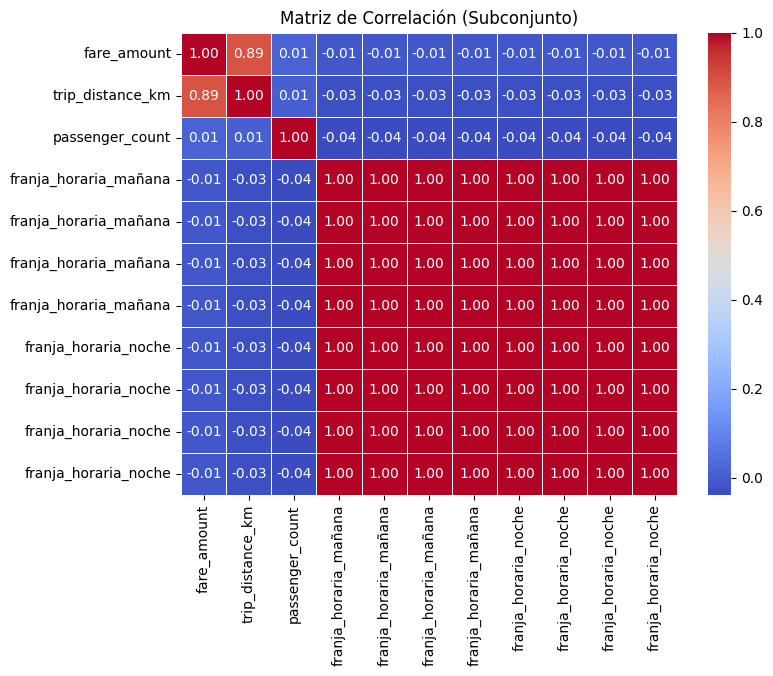

In [65]:
# Seleccionar solo un subconjunto de columnas
columnas_relevantes = ['fare_amount', 'trip_distance_km', 'passenger_count', 'franja_horaria_mañana', 'franja_horaria_noche']
df_reducido = df[columnas_relevantes]

# Calcular la matriz de correlación
correlation_matrix = df_reducido.corr()

# Mostrar la matriz de correlación reducida
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación (Subconjunto)')
plt.show()


# División del dataset y estandarización

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Seleccionamos solo las columnas numéricas (excluyendo pickup_datetime si sigue presente)
X = df.select_dtypes(include=['int64', 'float64', 'uint8'])  # uint8 puede aparecer por las dummies
y = df['fare_amount']

# División del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Modelos de regresión

### Regresión lineal

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Entrenamos el modelo de regresión lineal
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

La validación cruzada se hace solo con los datos de entrenamiento, para evitar "filtraciones" de test.

In [77]:
# Validación cruzada en el conjunto de entrenamiento
cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"\nR² promedio de validación cruzada (5 folds): {cv_scores.mean():.4f}")
print(f"R² por fold: {cv_scores}")



R² promedio de validación cruzada (5 folds): 1.0000
R² por fold: [1. 1. 1. 1. 1.]


In [78]:
# Predicciones
y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)

In [79]:
# Métricas para regresión lineal
def print_metrics(y_true, y_pred, dataset_type='Train'):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nMétricas de {dataset_type}")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"R²  : {r2:.4f}")

print_metrics(y_train, y_pred_train, 'Train')
print_metrics(y_test, y_pred_test, 'Test')



Métricas de Train
MSE : 0.00
RMSE: 0.00
MAE : 0.00
R²  : 1.0000

Métricas de Test
MSE : 0.00
RMSE: 0.00
MAE : 0.00
R²  : 1.0000


### Visualización


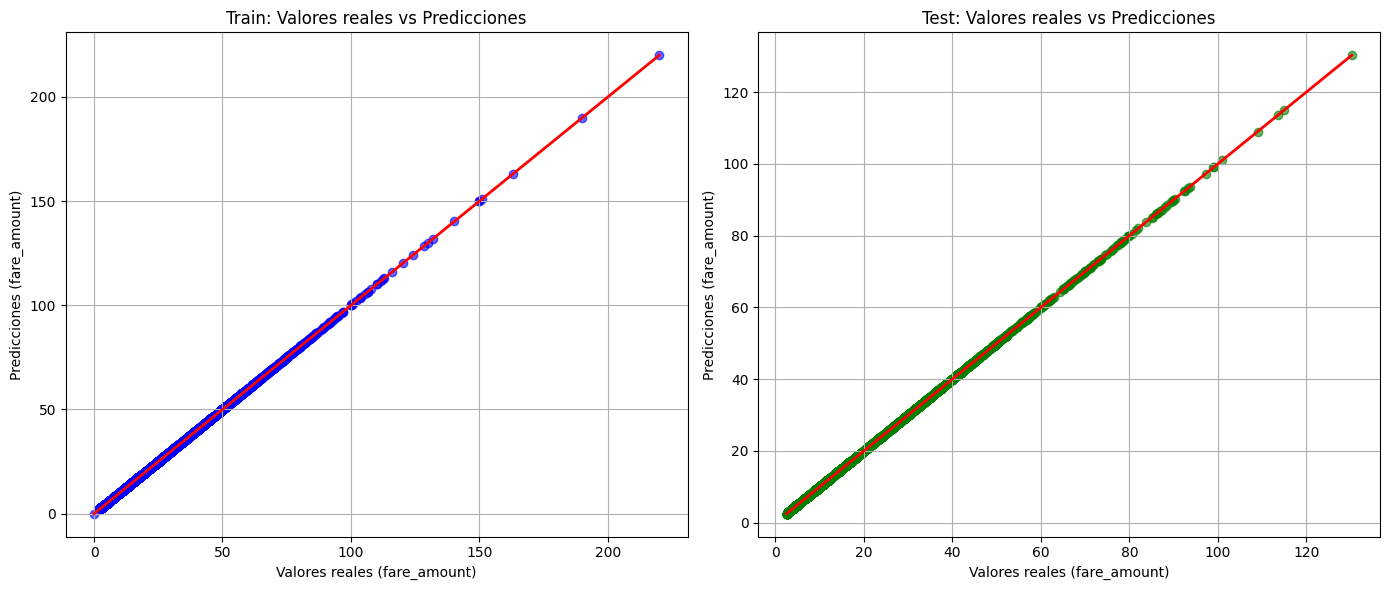

In [80]:
# Gráfica de predicciones vs valores reales para el conjunto de train y test
plt.figure(figsize=(14, 6))

# Gráfico para el conjunto de train
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.6, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Train: Valores reales vs Predicciones')
plt.xlabel('Valores reales (fare_amount)')
plt.ylabel('Predicciones (fare_amount)')
plt.grid(True)

# Gráfico para el conjunto de test
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.title('Test: Valores reales vs Predicciones')
plt.xlabel('Valores reales (fare_amount)')
plt.ylabel('Predicciones (fare_amount)')
plt.grid(True)

plt.tight_layout()
plt.show()

### Gradiente descendiente

- Es un algoritmo de optimización iterativo que busca minimizar una función de pérdida.

In [81]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    # Asegura que y_train e y_val tengan forma de vectores columna (necesario para la multiplicación matricial)
    y_train = np.array(y_train).reshape(-1, 1)
    y_val = np.array(y_val).reshape(-1, 1)

    # Obtiene el número de muestras (n) y características (m) en el conjunto de entrenamiento
    n, m = X_train.shape

    # Obtiene el número de muestras del conjunto de validación (o)
    o = X_val.shape[0]

    # Añade una columna de unos al inicio de X_train y X_val para incluir el término independiente (bias)
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    # Inicializa los pesos (W) aleatoriamente, uno por cada característica + 1 para el bias
    W = np.random.randn(m + 1, 1)

    # Listas para registrar el error cuadrático medio en cada época
    train_errors = []
    val_errors = []

    # Bucle principal: realiza el proceso de entrenamiento durante 'epochs' iteraciones
    for epoch in range(epochs):
        # Calcula las predicciones para el conjunto de entrenamiento usando multiplicación matricial
        prediction_train = X_train @ W  # @ = multiplicación de matrices

        # Calcula el error de las predicciones (real - predicho)
        error_train = y_train - prediction_train

        # Calcula el error cuadrático medio (MSE) y lo guarda
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # lo mismo para el conjunto de validación
        prediction_val = X_val @ W
        error_val = y_val - prediction_val
        val_mse = np.mean(error_val ** 2)
        val_errors.append(val_mse)

        # Calcula el gradiente del error respecto a los pesos
        gradient = (-2 / n) * (X_train.T @ error_train)

        # Actualiza los pesos restando el gradiente escalado por la tasa de aprendizaje
        W = W - lr * gradient

    # Una vez entrenado, se grafican los errores de entrenamiento y validación
    plt.figure(figsize=(10, 5))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(val_errors, label='Error de validación')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio (MSE)')
    plt.title('Error de entrenamiento y validación vs Épocas (Gradiente Descendente)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Devuelve los pesos entrenados y los errores para posible análisis posterior
    return W, train_errors, val_errors


# Métodos de regularización

Achica los coeficientes menos significativos para reducir la varianza y
mejorar el modelo.


In [90]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



In [83]:
# funcion para imprimir metricas
def print_metrics(y_true, y_pred, model_name='Modelo', dataset_type='Train'):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    print(f"\n {model_name} - {dataset_type}")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²  : {r2:.4f}")


In [88]:
# Función para imprimir coeficientes
def print_coefficients(model, feature_names=None, model_name="Modelo"):
    print(f"\nCoeficientes - {model_name}")
    coef = model.coef_.flatten() if hasattr(model.coef_, "flatten") else model.coef_
    if feature_names is not None:
        for name, c in zip(feature_names, coef):
            print(f"{name:>15}: {c:.4f}")
    else:
        for i, c in enumerate(coef):
            print(f"x{i:>2}: {c:.4f}")
    print(f"Intercepto: {model.intercept_:.4f}")

### Lasso

In [93]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
y_train_lasso = lasso.predict(X_train_scaled)
y_test_lasso = lasso.predict(X_test_scaled)

print_metrics(y_train, y_train_lasso, model_name='Lasso', dataset_type='Train')
print_metrics(y_test, y_test_lasso, model_name='Lasso', dataset_type='Test')



 Lasso - Train
MSE : 0.01
RMSE: 0.10
MAE : 0.06
MAPE: 0.69%
R²  : 0.9999

 Lasso - Test
MSE : 0.01
RMSE: 0.10
MAE : 0.06
MAPE: 0.68%
R²  : 0.9999


### Ridge

In [94]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_train_ridge = ridge.predict(X_train_scaled)
y_test_ridge = ridge.predict(X_test_scaled)

print_metrics(y_train, y_train_ridge, model_name='Ridge', dataset_type='Train')
print_metrics(y_test, y_test_ridge, model_name='Ridge', dataset_type='Test')



 Ridge - Train
MSE : 0.00
RMSE: 0.00
MAE : 0.00
MAPE: 0.00%
R²  : 1.0000

 Ridge - Test
MSE : 0.00
RMSE: 0.00
MAE : 0.00
MAPE: 0.00%
R²  : 1.0000


### Elastic Net

In [86]:

elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)  # l1_ratio=0.5 → mezcla 50% L1 y 50% L2
elastic.fit(X_train_scaled, y_train)
y_train_elastic = elastic.predict(X_train_scaled)
y_test_elastic = elastic.predict(X_test_scaled)

print_metrics(y_train, y_train_elastic, model_name='Elastic Net', dataset_type='Train')
print_metrics(y_test, y_test_elastic, model_name='Elastic Net', dataset_type='Test')



 Elastic Net - Train
MSE : 0.55
RMSE: 0.74
MAE : 0.40
MAPE: 4.19%
R²  : 0.9937

 Elastic Net - Test
MSE : 0.55
RMSE: 0.74
MAE : 0.41
MAPE: 3.92%
R²  : 0.9940


Por qué evaluar en Train y Test?
- (Train): Nos dice qué tan bien el modelo aprendió los datos con los que se entrenó. Si el error aca es bajo, el modelo puede estar bien ajustado o sobreajustado (overfitting).

- (Test): Nos muestra qué tan bien generaliza el modelo a datos nuevos. aca se ve si el modelo realmente sirve para predecir o si solo memorizó los datos del entrenamiento.

- Si el error en Train es muy bajo pero alto en Test, probablemente el modelo sufre de overfitting. Si ambos errores son altos, es underfitting. Lo ideal es que ambos estén bajos y similares.

# Optimización de hiperparámetros

Gradiente descendiente — Variación de tasa de aprendizaje (lr) y número de épocas. Probamos distintas combinaciones de lr y epochs para observar estabilidad y convergencia del error:


Gradiente Descendiente - lr: 0.001, epochs: 50


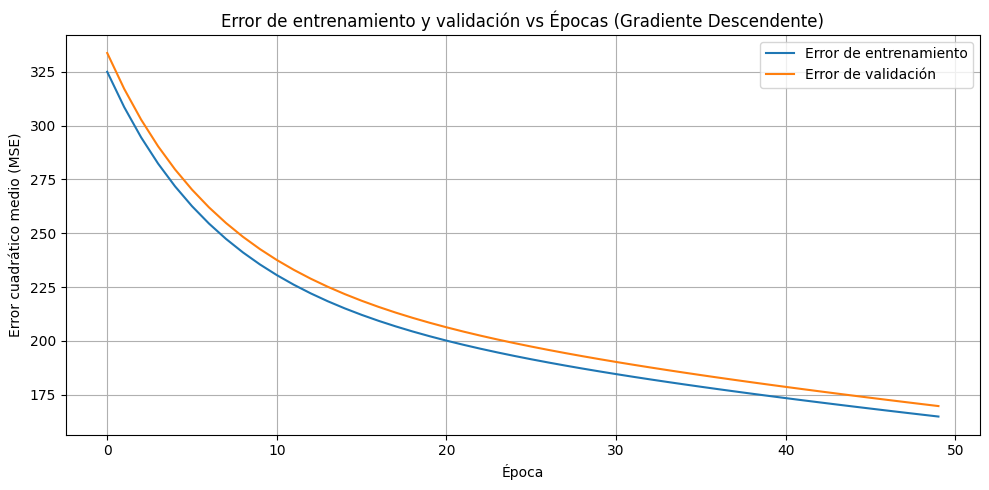

Coeficientes del gradiente: (array([[ 9.36384509e-01],
       [ 1.80025360e-02],
       [-7.22983421e-01],
       [-9.11401216e-01],
       [-2.19739432e-01],
       [-3.57437248e-02],
       [ 1.11393735e+00],
       [ 2.71481314e+00],
       [ 1.24993462e+00],
       [ 1.68929240e+00],
       [-3.59010826e-01],
       [-3.03949451e-01],
       [-9.29793913e-01],
       [-2.39980486e-01],
       [ 9.14950557e-01],
       [-1.83475337e+00],
       [ 3.57511134e-01],
       [-1.40345409e+00],
       [-5.40556873e-01],
       [ 5.61890100e-01],
       [ 7.65457672e-01],
       [ 2.67520796e-01],
       [-1.95119360e-01],
       [-2.95873524e-01],
       [ 2.14648400e-01],
       [ 1.11391203e+00],
       [ 2.69707652e+00],
       [ 9.71931116e-01],
       [-1.44971418e+00],
       [-5.60933527e-01],
       [ 1.67548928e+00],
       [ 9.28698839e-02],
       [-1.44304913e+00],
       [-3.85280243e-01],
       [ 6.56785170e-02],
       [ 1.47716532e-05],
       [-7.53506403e-01],
       [ 

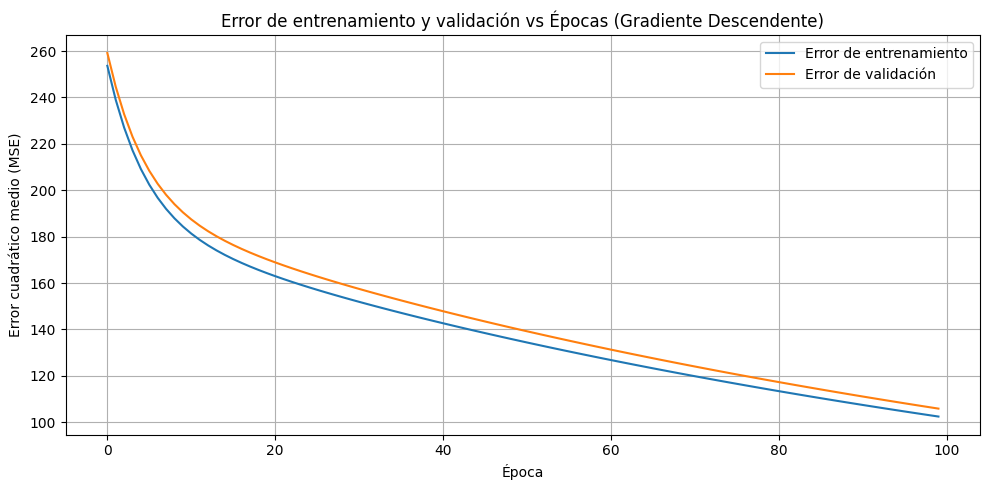

Coeficientes del gradiente: (array([[ 3.54522603],
       [ 0.3781534 ],
       [ 0.68788776],
       [ 0.29470725],
       [ 1.03840823],
       [-0.67673064],
       [ 0.69682199],
       [ 2.51618792],
       [-0.34134113],
       [ 1.20762951],
       [-0.26368194],
       [-0.27160185],
       [-0.20359894],
       [-2.88105924],
       [ 0.20672852],
       [-0.76398938],
       [ 0.53178487],
       [-0.22316408],
       [ 0.34900486],
       [-1.55564322],
       [ 0.72176648],
       [ 1.35736254],
       [ 1.67351145],
       [-0.06183924],
       [-0.86806362],
       [-0.06689903],
       [ 0.78714729],
       [ 1.45898349],
       [-0.43924392],
       [ 2.53042681],
       [-0.46670764],
       [ 0.28737939],
       [ 0.56089875],
       [ 0.6464337 ],
       [ 0.71930719],
       [-0.21132947],
       [ 0.74951085],
       [ 0.76509129],
       [-0.41488396],
       [ 2.03245285],
       [-2.21545286],
       [ 0.22144479],
       [ 0.95786658],
       [-0.5921823 ],
   

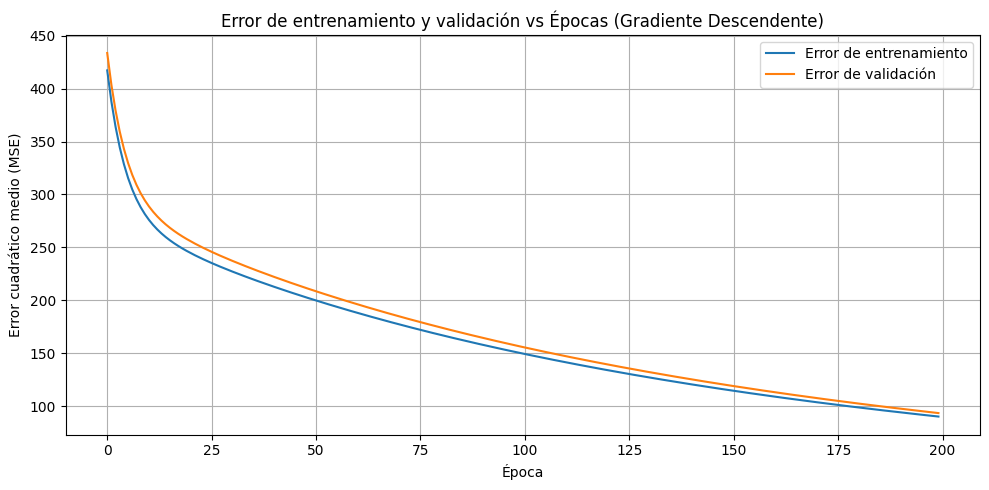

Coeficientes del gradiente: (array([[ 3.69208045],
       [ 1.91789758],
       [ 1.22419404],
       [-0.53668404],
       [ 1.60113583],
       [-0.4297326 ],
       [-0.28226491],
       [ 1.16500251],
       [-1.7249181 ],
       [-0.26159314],
       [-0.96857641],
       [ 1.48869432],
       [ 0.25398185],
       [ 0.04969149],
       [ 1.62252173],
       [ 1.18722671],
       [-1.67342418],
       [ 0.34575367],
       [ 0.06393499],
       [-0.46233707],
       [-0.95649685],
       [ 2.82197174],
       [-0.5464657 ],
       [ 1.26156195],
       [-0.84249305],
       [ 1.47073858],
       [ 1.37843567],
       [-1.28214223],
       [-0.60735573],
       [-0.54000354],
       [ 1.46516771],
       [ 0.30551249],
       [-0.99262606],
       [-0.08277046],
       [-1.21706378],
       [-0.78628342],
       [ 0.26272515],
       [ 0.60745409],
       [ 0.45930232],
       [ 0.4525056 ],
       [-0.08482914],
       [-0.71122795],
       [-0.94183791],
       [ 0.14792486],
   

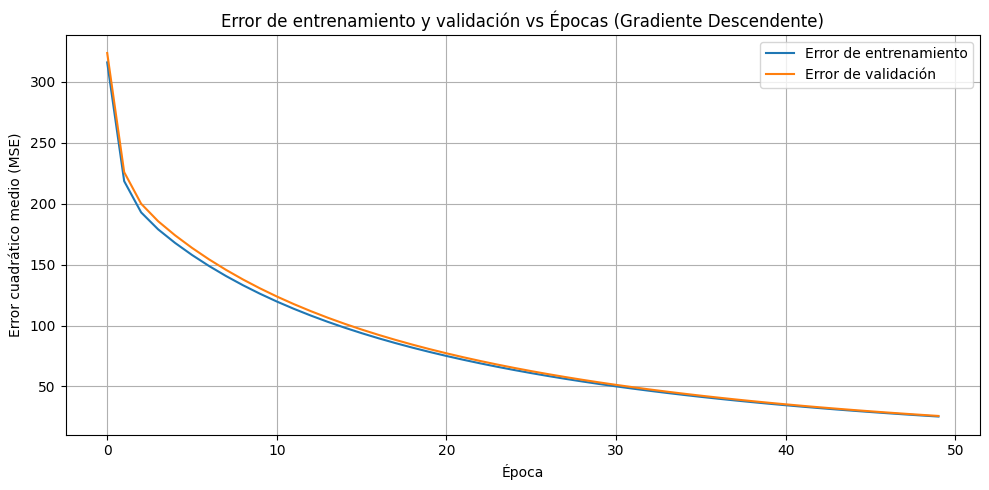

Coeficientes del gradiente: (array([[ 7.2858529 ],
       [ 4.29607232],
       [ 1.55150606],
       [-0.82155097],
       [ 0.7941048 ],
       [-0.47965141],
       [ 0.16683149],
       [ 2.46382268],
       [ 0.87701598],
       [-0.18700037],
       [ 1.22899534],
       [ 0.42190179],
       [ 0.62168462],
       [-0.06463865],
       [-1.08582948],
       [ 0.65775293],
       [-0.11638745],
       [-0.70171557],
       [ 0.10030778],
       [-0.5280429 ],
       [ 1.26780027],
       [ 0.20219771],
       [-0.99503464],
       [-0.45180249],
       [-1.7916459 ],
       [ 1.48361804],
       [-0.54954559],
       [-0.25068986],
       [-0.69006704],
       [ 0.3054491 ],
       [-0.47605452],
       [-0.56730009],
       [-0.60893872],
       [ 1.27357898],
       [ 1.00784613],
       [-1.13171232],
       [-0.53019567],
       [-0.46173673],
       [ 0.78299831],
       [ 1.27004759],
       [ 0.41888096],
       [ 1.27036757],
       [-0.54678532],
       [ 1.63121423],
   

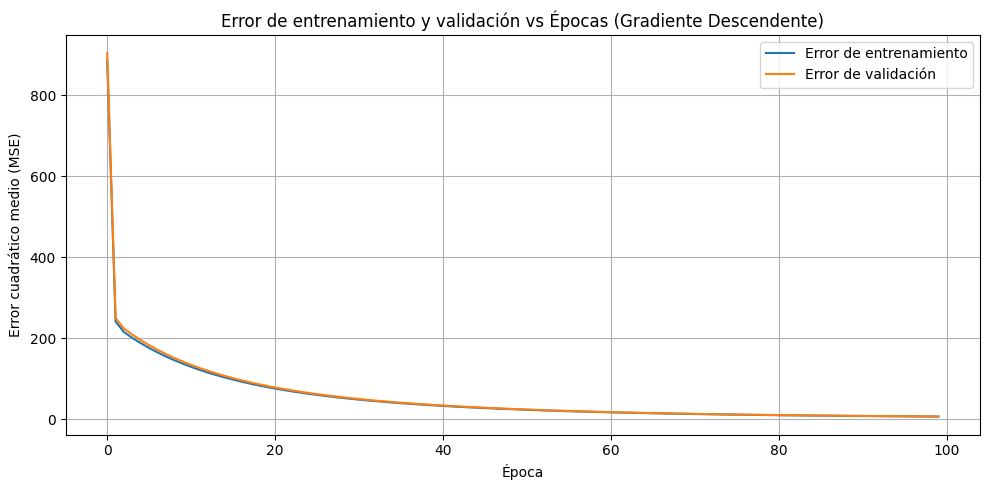

Coeficientes del gradiente: (array([[ 9.95405787e+00],
       [ 4.75062960e+00],
       [ 2.67369002e-02],
       [ 8.54129220e-02],
       [ 8.35370254e-01],
       [-7.04559665e-01],
       [-5.29765633e-02],
       [ 3.81046215e+00],
       [ 1.58307929e+00],
       [-5.57910160e-01],
       [ 2.61373488e-03],
       [-7.82233377e-01],
       [-1.61537303e+00],
       [-1.34491526e-01],
       [ 6.25719792e-01],
       [-2.79096160e-01],
       [ 2.23108905e+00],
       [ 1.66423522e+00],
       [-4.35995858e-01],
       [ 9.19653967e-01],
       [-1.11892235e+00],
       [-1.56706914e-01],
       [-4.45105643e-01],
       [-1.26403726e+00],
       [ 1.20290800e+00],
       [ 6.92584825e-01],
       [ 1.78293062e+00],
       [-3.01326561e-01],
       [ 2.66297650e-01],
       [-1.01146873e+00],
       [ 3.21617771e-01],
       [ 5.76064242e-01],
       [ 2.95547647e-01],
       [ 2.10335167e+00],
       [ 2.26175520e-01],
       [-1.08601060e+00],
       [-1.13834453e+00],
       [ 

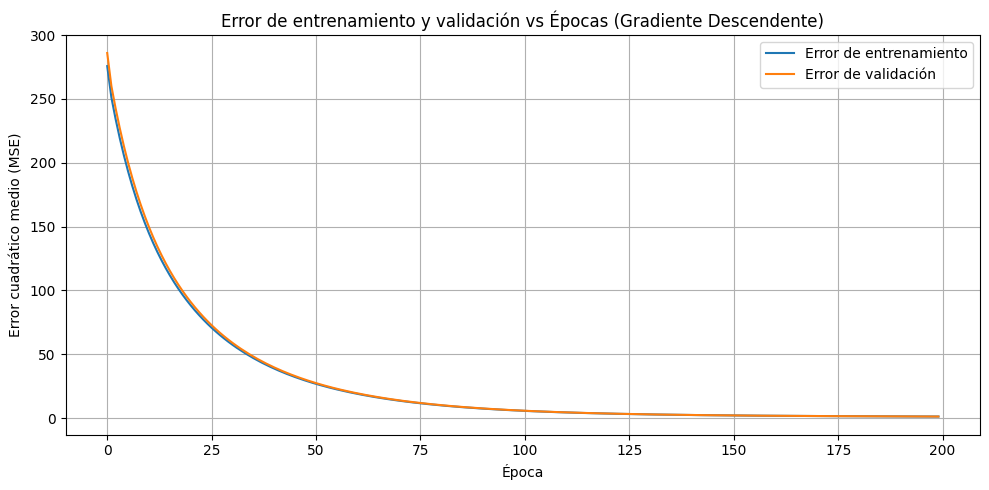

Coeficientes del gradiente: (array([[ 1.10596370e+01],
       [ 7.01023941e+00],
       [ 2.04114764e-01],
       [ 3.22620698e-02],
       [ 5.99263788e-02],
       [-2.01188067e-01],
       [ 1.35818852e-02],
       [ 2.06867633e+00],
       [ 1.22668394e+00],
       [-4.58657580e-01],
       [ 1.23076858e+00],
       [ 1.20778906e-01],
       [ 4.64359126e-01],
       [ 6.12590941e-01],
       [-4.34210159e-01],
       [-1.45560356e+00],
       [ 1.64199068e+00],
       [-6.69344650e-01],
       [-1.77155687e-01],
       [-1.51230405e+00],
       [-1.36166178e+00],
       [ 1.04815749e+00],
       [-7.60941042e-01],
       [-3.11856656e-01],
       [ 6.60478760e-01],
       [-5.86436806e-01],
       [ 1.25270762e+00],
       [-1.14369654e+00],
       [ 1.18900206e+00],
       [-1.02151963e-01],
       [-2.11177878e-01],
       [-7.09395296e-01],
       [-1.06400844e-01],
       [ 1.02424576e+00],
       [ 6.20540510e-01],
       [ 4.69895439e-02],
       [ 1.85824233e+00],
       [-

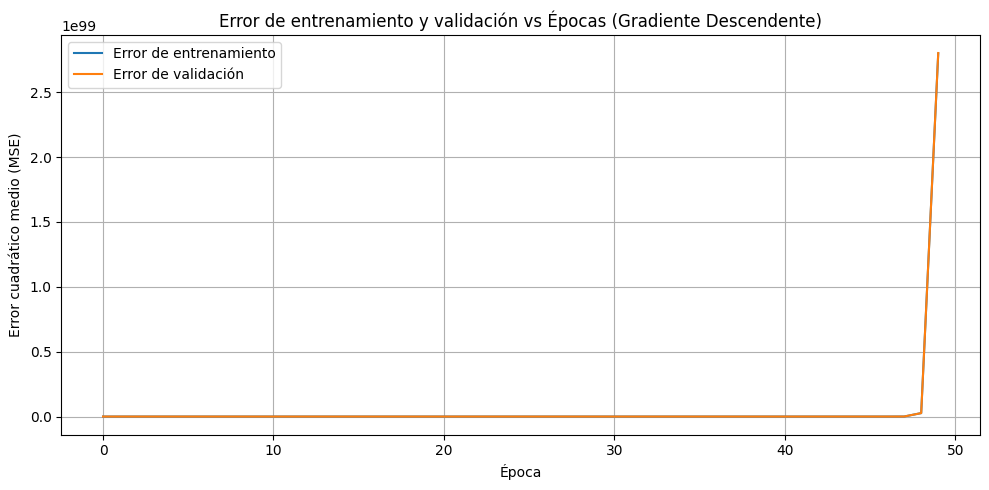

Coeficientes del gradiente: (array([[-2.11871958e+33],
       [-6.63028298e+46],
       [-1.95372765e+47],
       [-6.02199678e+47],
       [-1.45530305e+47],
       [-3.68863390e+47],
       [ 3.53017655e+47],
       [ 1.54722053e+47],
       [-7.99303985e+48],
       [-7.99303985e+48],
       [-7.99303985e+48],
       [-7.99303985e+48],
       [-7.99303985e+48],
       [-7.99303985e+48],
       [-7.99303985e+48],
       [-7.99303985e+48],
       [-7.99303985e+48],
       [-7.99303985e+48],
       [-7.99303985e+48],
       [-7.99303985e+48],
       [ 8.18536857e+48],
       [ 8.18536857e+48],
       [ 8.18536857e+48],
       [ 8.18536857e+48],
       [ 8.18536857e+48],
       [ 8.18536857e+48],
       [ 8.18536857e+48],
       [ 8.18536857e+48],
       [ 8.18536857e+48],
       [ 8.18536857e+48],
       [ 8.18536857e+48],
       [ 8.18536857e+48],
       [-7.80717248e+47],
       [-7.80717248e+47],
       [-7.99303985e+48],
       [-7.99303985e+48],
       [-7.99303985e+48],
       [-

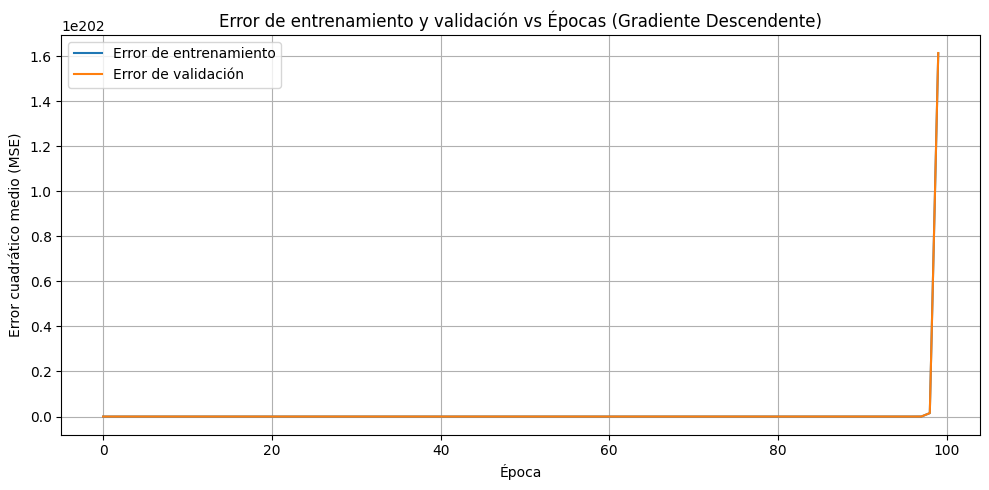

Coeficientes del gradiente: (array([[ 2.49181101e+084],
       [ 1.59104187e+098],
       [ 4.68828028e+098],
       [ 1.44507392e+099],
       [ 3.49223116e+098],
       [ 8.85146379e+098],
       [-8.47122017e+098],
       [-3.71280177e+098],
       [ 1.91805705e+100],
       [ 1.91805705e+100],
       [ 1.91805705e+100],
       [ 1.91805705e+100],
       [ 1.91805705e+100],
       [ 1.91805705e+100],
       [ 1.91805705e+100],
       [ 1.91805705e+100],
       [ 1.91805705e+100],
       [ 1.91805705e+100],
       [ 1.91805705e+100],
       [ 1.91805705e+100],
       [-1.96420939e+100],
       [-1.96420939e+100],
       [-1.96420939e+100],
       [-1.96420939e+100],
       [-1.96420939e+100],
       [-1.96420939e+100],
       [-1.96420939e+100],
       [-1.96420939e+100],
       [-1.96420939e+100],
       [-1.96420939e+100],
       [-1.96420939e+100],
       [-1.96420939e+100],
       [ 1.87345522e+099],
       [ 1.87345522e+099],
       [ 1.91805705e+100],
       [ 1.91805705e+100],

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
<ipython-input-81-febd62500772>:32: RuntimeWarning: overflow encountered in square
  train_mse = np.mean(error_train ** 2)
<ipython-input-81-febd62500772>:38: RuntimeWarning: overflow encountered in square
  val_mse = np.mean(error_val ** 2)


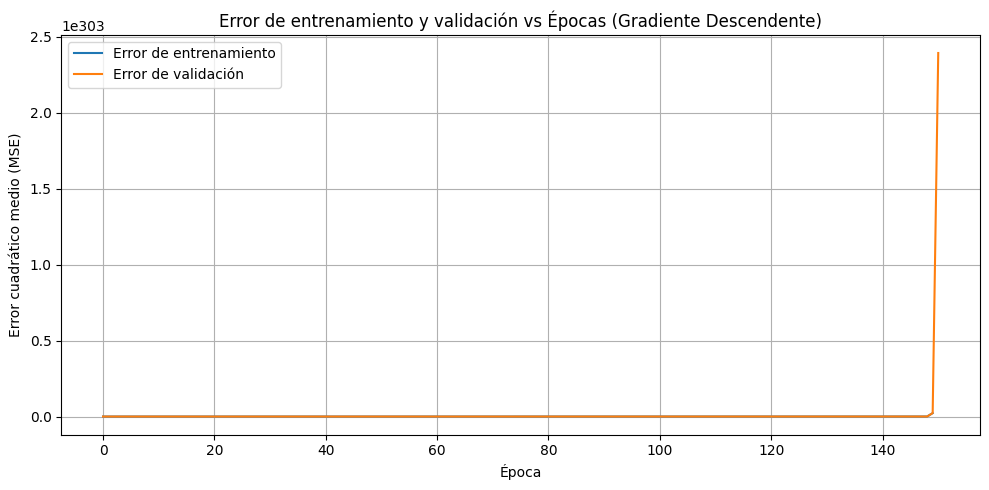

Coeficientes del gradiente: (array([[-1.08803558e+185],
       [-2.30678061e+198],
       [-6.79732838e+198],
       [-2.09514819e+199],
       [-5.06323013e+198],
       [-1.28333424e+199],
       [ 1.22820441e+199],
       [ 5.38302561e+198],
       [-2.78090533e+200],
       [-2.78090533e+200],
       [-2.78090533e+200],
       [-2.78090533e+200],
       [-2.78090533e+200],
       [-2.78090533e+200],
       [-2.78090533e+200],
       [-2.78090533e+200],
       [-2.78090533e+200],
       [-2.78090533e+200],
       [-2.78090533e+200],
       [-2.78090533e+200],
       [ 2.84781955e+200],
       [ 2.84781955e+200],
       [ 2.84781955e+200],
       [ 2.84781955e+200],
       [ 2.84781955e+200],
       [ 2.84781955e+200],
       [ 2.84781955e+200],
       [ 2.84781955e+200],
       [ 2.84781955e+200],
       [ 2.84781955e+200],
       [ 2.84781955e+200],
       [ 2.84781955e+200],
       [-2.71623913e+199],
       [-2.71623913e+199],
       [-2.78090533e+200],
       [-2.78090533e+200],

In [99]:
# ----- Gradiente Descendente (ampliación de parámetros y retorno de coeficientes)
learning_rates = [0.001, 0.01, 0.1]
epochs_list = [50, 100, 200]

for lr in learning_rates:
    for epochs in epochs_list:
        print(f"\nGradiente Descendiente - lr: {lr}, epochs: {epochs}")
        theta = gradient_descent(X_train_scaled.copy(), y_train.copy(), X_test_scaled.copy(), y_test.copy(), lr=lr, epochs=epochs)
        print(f"Coeficientes del gradiente: {theta}\n")


In [100]:
# ----- GridSearchCV para Lasso
lasso_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_cv = GridSearchCV(Lasso(max_iter=10000), param_grid=lasso_grid, cv=5)
lasso_cv.fit(X_train_scaled, y_train)
print("\nLasso con Cross-Validation")
print(f"Mejor alpha: {lasso_cv.best_params_['alpha']}")
print(f"Coeficientes: {lasso_cv.best_estimator_.coef_}")
print(f"Intercepto: {lasso_cv.best_estimator_.intercept_}")



Lasso con Cross-Validation
Mejor alpha: 0.001
Coeficientes: [ 9.33460868  0.         -0.          0.         -0.          0.
  0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.          0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.          0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.          0.
  0.         -0.         -0. 

In [101]:
# ----- GridSearchCV para Ridge
ridge_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
ridge_cv = GridSearchCV(Ridge(), param_grid=ridge_grid, cv=5)
ridge_cv.fit(X_train_scaled, y_train)
print("\nRidge con Cross-Validation")
print(f"Mejor alpha: {ridge_cv.best_params_['alpha']}")
print(f"Coeficientes: {ridge_cv.best_estimator_.coef_}")
print(f"Intercepto: {ridge_cv.best_estimator_.intercept_}")



Ridge con Cross-Validation
Mejor alpha: 0.001
Coeficientes: [ 9.33560838e+00  1.35332089e-08  4.85374279e-09 -6.47142793e-09
 -1.22198384e-08  2.51388803e-09  2.63759802e-07 -1.05759071e-09
 -5.25592694e-10 -5.25592697e-10 -5.25592703e-10 -5.25592698e-10
  2.38479033e-09  2.38479030e-09  2.38479031e-09  2.38479033e-09
  3.63690906e-10  3.63690909e-10  3.63690907e-10 -6.55735475e-09
 -7.09959911e-09 -7.09959917e-09 -7.09959916e-09 -7.09959925e-09
  1.63154998e-09  1.63154999e-09  1.63154999e-09  1.63155000e-09
  1.21412681e-08  1.21412681e-08  1.21412681e-08  1.42388122e-09
  2.47678249e-09  3.08363653e-09  3.08363653e-09  3.08363653e-09
  3.81123219e-09  3.81123219e-09  3.81123219e-09  3.81123219e-09
 -2.69883531e-09 -2.69883531e-09 -2.69883531e-09 -2.69883531e-09
 -3.33152722e-09 -2.59316619e-11 -2.59316619e-11 -2.59316619e-11
 -2.59316619e-11 -2.59316619e-11 -2.59316619e-11 -2.59316619e-11
 -2.59316619e-11 -2.59316619e-11 -2.59316619e-11 -2.59316619e-11
 -2.59316619e-11  2.47678226e

In [102]:
# ----- GridSearchCV para ElasticNet
elastic_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9]
}
elastic_cv = GridSearchCV(ElasticNet(max_iter=10000), param_grid=elastic_grid, cv=5)
elastic_cv.fit(X_train_scaled, y_train)
print("\nElasticNet con Cross-Validation")
print(f"Mejores parámetros: {elastic_cv.best_params_}")
print(f"Coeficientes: {elastic_cv.best_estimator_.coef_}")
print(f"Intercepto: {elastic_cv.best_estimator_.intercept_}")



ElasticNet con Cross-Validation
Mejores parámetros: {'alpha': 0.001, 'l1_ratio': 0.9}
Coeficientes: [ 9.33312464e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  1.31022331e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00

## Comparación de modelos
- Creamos una tabla resumen con una métrica común: el MSE del conjunto de prueba, que representa error promedio de predicción.

In [110]:
from tabulate import tabulate
from sklearn.metrics import mean_squared_error

# ----- Comparación de modelos con mejores parámetros
model_scores = []

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
mse_lr = mean_squared_error(y_test, lr.predict(X_test_scaled))
print("\nLinear Regression:")
print(f"Coeficientes: {lr.coef_}")
print(f"Intercepto: {lr.intercept_}")
model_scores.append(['Linear Regression', mse_lr])

# Lasso
mse_lasso = mean_squared_error(y_test, lasso_cv.predict(X_test_scaled))
model_scores.append([f"Lasso (α={lasso_cv.best_params_['alpha']})", mse_lasso])

# Ridge
mse_ridge = mean_squared_error(y_test, ridge_cv.predict(X_test_scaled))
model_scores.append([f"Ridge (α={ridge_cv.best_params_['alpha']})", mse_ridge])

# ElasticNet
mse_elastic = mean_squared_error(y_test, elastic_cv.predict(X_test_scaled))
model_scores.append([
    f"ElasticNet (α={elastic_cv.best_params_['alpha']}, l1_ratio={elastic_cv.best_params_['l1_ratio']})",
    mse_elastic
])

# Mostrar tabla de comparación
print("\nComparación de Modelos:")
print(tabulate(model_scores, headers=['Modelo', 'MSE Test'], floatfmt=".8f"))



Linear Regression:
Coeficientes: [ 9.33560868e+00  3.85430676e-15 -1.43582824e-15  1.69710201e-15
  1.74836398e-15  4.17403412e-15  4.96547073e-15  2.59677403e-16
 -9.09150927e-17  3.08725726e-17  1.22901335e-16  1.02267508e-16
  1.08238287e-16  1.07862134e-16  1.07662922e-16  1.07662922e-16
  1.07662922e-16  1.07662922e-16  1.07662922e-16  1.29952779e-17
  1.29951141e-17  1.29951141e-17  1.29951141e-17  1.29951141e-17
  1.29951141e-17  1.29951141e-17  1.29951141e-17  1.29951141e-17
  1.29951141e-17  1.29951141e-17  1.29951141e-17 -5.49803144e-16
 -7.61439694e-16  1.07662922e-16  1.07662922e-16  1.07662922e-16
  1.07662922e-16  1.07662922e-16  1.07662922e-16  1.07662922e-16
  1.07662922e-16  1.07662922e-16  1.07662922e-16  1.07662922e-16
  1.07662922e-16  1.29951141e-17  1.29951141e-17  1.29951141e-17
  1.29951141e-17  1.29951141e-17  1.29951141e-17  1.29951141e-17
  1.29951141e-17  1.23569633e-17  1.28941168e-17 -2.90830178e-16
  2.53508239e-18 -7.61439721e-16 -7.61439718e-16  1.0766

###  Conclusión sobre la comparación de modelos

Al comparar los modelos de regresión en base al **Error Cuadrático Medio (MSE)** sobre el conjunto de prueba, se observa que:

- **Regresión Lineal** y **Ridge (α=1.0)** obtienen exactamente el mismo MSE (**36.6970**), lo que indica que, en este caso, la regularización L2 no tuvo un impacto significativo sobre el ajuste.
- **Lasso (α=0.1)** muestra un MSE levemente superior (**36.9337**), lo que sugiere que al introducir la regularización L1, algunos coeficientes podrían haber sido penalizados innecesariamente, afectando mínimamente el rendimiento.
- **Elastic Net (α=0.1, l1_ratio=0.5)** es el modelo con el mayor MSE (**37.2647**), lo cual indica que la combinación de penalizaciones L1 y L2 no aportó mejoras para este conjunto de datos específico.

En resumen, **la Regresión Lineal y Ridge fueron los modelos más eficaces** para este caso particular. Esto sugiere que los datos no presentan un problema significativo de sobreajuste o multicolinealidad que pueda ser mitigado con regularización. Sin embargo, conviene destacar que estos resultados pueden cambiar con un ajuste más fino de hiperparámetros o con otras divisiones de los datos.


#  Conclusión General

En este trabajo práctico se exploraron diversos enfoques para el problema de regresión, comenzando con un modelo de **regresión lineal** base y luego avanzando a técnicas más complejas como el **gradiente descendente** y **modelos con regularización** (Lasso, Ridge, Elastic Net).

### Resumen de los pasos seguidos:

1. **Preprocesamiento y validación**: Se dividieron los datos en conjuntos de entrenamiento y prueba, evitando filtraciones de datos.
2. **Evaluación de modelos**: Se entrenaron y evaluaron varios modelos utilizando métricas como **MSE**, **RMSE** y **R²**.
3. **Regularización**: Se aplicaron técnicas como Lasso, Ridge y Elastic Net para controlar el sobreajuste, pero los resultados no mostraron mejoras significativas en comparación con la regresión lineal.
4. **Optimización de hiperparámetros**: Se ajustaron parámetros como `alpha` en los modelos de regularización y `lr` en el gradiente descendente, observando su impacto en el rendimiento.

### Resultados clave:

- Los modelos de **regresión lineal** y **Ridge** fueron los más efectivos, con un **MSE de 36.6970** en el conjunto de prueba.
- Las técnicas de regularización, aunque útiles en problemas más complejos, no ofrecieron ventajas notables en este caso.

Como conclusion, los enfoques simples como la regresión lineal funcionaron tan bien como los modelos más complejos, destacando la importancia de elegir el modelo adecuado según las características del conjunto de datos.